In [1]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 5.4 MB/s 


Path: /content/drive/My Drive/Indian-celebrities/without_mask/Aesha_Gabhawala/WhatsApp Image 2021-10-09 at 6.11.13 PM.jpeg
Path: /content/drive/My Drive/Indian-celebrities/without_mask/Aesha_Gabhawala/WhatsApp Image 2021-11-22 at 8.44.46 PM.jpeg
Path: /content/drive/My Drive/Indian-celebrities/without_mask/Aesha_Gabhawala/WhatsApp Image 2021-11-22 at 8.44.46 PM (1).jpeg
Path: /content/drive/My Drive/Indian-celebrities/without_mask/Aesha_Gabhawala/WhatsApp Image 2021-11-22 at 8.44.46 PM (2).jpeg
Path: /content/drive/My Drive/Indian-celebrities/without_mask/Aesha_Gabhawala/WhatsApp Image 2021-11-22 at 8.44.46 PM (3).jpeg
Path: /content/drive/My Drive/Indian-celebrities/without_mask/Aesha_Gabhawala/WhatsApp Image 2021-11-22 at 8.44.46 PM (4).jpeg
Path: /content/drive/My Drive/Indian-celebrities/without_mask/Aesha_Gabhawala/WhatsApp Image 2021-11-22 at 8.44.46 PM (5).jpeg
Path: /content/drive/My Drive/Indian-celebrities/without_mask/Aesha_Gabhawala/WhatsApp Image 2021-11-22 at 8.44.46 PM (

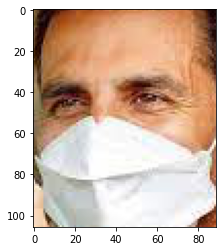

In [15]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from PIL import Image 
from numpy import savez_compressed
from numpy import asarray
from os import listdir
from mtcnn.mtcnn import MTCNN

#Method to extract Face
def extract_image(image):
  img1 = Image.open(image)            #open the image
  img1 = img1.convert('RGB')          #convert the image to RGB format 
  pixels = asarray(img1)              #convert the image to numpy array
  detector = MTCNN()                  #assign the MTCNN detector
  f = detector.detect_faces(pixels)
  #fetching the (x,y)co-ordinate and (width-->w, height-->h) of the image
  x1,y1,w,h = f[0]['box']             
  x1, y1 = abs(x1), abs(y1)
  x2 = abs(x1+w)
  y2 = abs(y1+h)
  #locate the co-ordinates of face in the image
  store_face = pixels[y1:y2,x1:x2]
  plt.imshow(store_face)
  image1 = Image.fromarray(store_face,'RGB')    #convert the numpy array to object
  image1 = image1.resize((160,160))             #resize the image
  face_array = asarray(image1)                  #image to array
  return face_array


#Method to fetch the face
def load_faces(directory):
  face = []
  i=1
  for filename in listdir(directory):
    path = directory + filename
    print('Path:',path)
    faces = extract_image(path)
    face.append(faces)
  return face


#Method to get the array of face data(trainX) and it's labels(trainY)
def load_dataset_mask(directory):
  x, y = [],[]
  i=1
  for subdir in ['Narendra_Modi','Akshay_Kumar']:#listdir(directory):
    path = directory + 'with_mask/' + subdir + '/'
    #load all faces in subdirectory
    faces = load_faces(path)
    #create labels
    labels = [subdir for _ in range(len(faces))]
    #summarize
    print("%d There are %d images in the class %s:"%(i,len(faces),subdir))
    x.extend(faces)
    y.extend(labels)
    print(i)
    i=i+1
  return asarray(x),asarray(y)

def load_dataset(directory):
  x, y = [],[]
  i=1
  for subdir in ['Aesha_Gabhawala','Vaani_Kapoor','Aamir_Khan','Abhay_Deol', 'Narendra_Modi','Akshay_Kumar']:#listdir(directory):
    path = directory + 'without_mask/' + subdir + '/'
    #load all faces in subdirectory
    faces = load_faces(path)
    #create labels
    labels = [subdir for _ in range(len(faces))]
    #summarize
    print("%d There are %d images in the class %s:"%(i,len(faces),subdir))
    x.extend(faces)
    y.extend(labels)
    print(i)
    i=i+1
  return asarray(x),asarray(y)  


#load the datasets
# if masked - load dataset with_mask otherwise without_mask
trainX,trainY = load_dataset('/content/drive/My Drive/Indian-celebrities/')
trainX_mask,trainY_mask = load_dataset_mask('/content/drive/My Drive/Indian-celebrities/')
print(trainX.shape,trainY.shape)
#compress the data
savez_compressed('/content/drive/My Drive/Indian-celeb-dataset.npz',trainX,trainY)
savez_compressed('/content/drive/My Drive/Indian-celeb-dataset-mask.npz',trainX_mask,trainY_mask)

In [16]:
from numpy import load
from numpy import asarray
from numpy import expand_dims
from numpy import savez_compressed
from numpy import reshape
from keras.models import load_model 

#Generalize the data and extract the embeddings
def extract_embeddings(model,face_pixels):
  face_pixels = face_pixels.astype('float32')  #convert the entire data to float32(base)
  mean = face_pixels.mean()                    #evaluate the mean of the data
  std  = face_pixels.std()                     #evaluate the standard deviation of the data
  face_pixels = (face_pixels - mean)/std       
  samples = expand_dims(face_pixels,axis=0)    #expand the dimension of data 
  yhat = model.predict(samples)
  return yhat[0]

#load the compressed dataset and facenet keras model
data = load('/content/drive/My Drive/Indian-celeb-dataset.npz')
data_mask = load('/content/drive/My Drive/Indian-celeb-dataset-mask.npz')
trainx, trainy = data['arr_0'],data['arr_1']
trainx_mask, trainy_mask = data_mask['arr_0'],data_mask['arr_1']

print(trainx.shape, trainy.shape)
print(trainx_mask.shape, trainy_mask.shape)
model = load_model('/content/drive/My Drive/facenet_keras.h5')

#get the face embeddings
new_trainx = list()
for train_pixels in trainx:
  embeddings = extract_embeddings(model,train_pixels)
  new_trainx.append(embeddings)
new_trainx = asarray(new_trainx)             #convert the embeddings into numpy array
print(new_trainx.shape)

new_trainx_mask = list()
for train_pixels in trainx_mask:
  embeddings = extract_embeddings(model,train_pixels)
  new_trainx_mask.append(embeddings)
new_trainx_mask = asarray(new_trainx_mask)
print(new_trainx_mask.shape)

#compress the 128 embeddings of each face 
savez_compressed('/content/drive/My Drive/Indian-celeb-embeddings.npz',new_trainx,trainy)
savez_compressed('/content/drive/My Drive/Indian-celeb-embeddings-mask.npz',new_trainx_mask,trainy_mask)

(82, 160, 160, 3) (82,)
(14, 160, 160, 3) (14,)
(82, 128)
(14, 128)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Input test data shape:  (1, 160, 160, 3)
Input test embedding shape:  (1, 128)
Loaded data: Train=14 , Test=1
Accuracy: 1.0


Text(0.5, 0, 'Predicted Data')

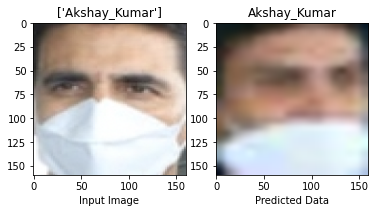

In [20]:
from matplotlib import pyplot as plt
from PIL import Image
from numpy import asarray
from numpy import array
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from numpy import expand_dims
from numpy import reshape
from numpy import load
from numpy import max
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

def extract_image(image):
  img1 = Image.open(image)
  img1 = img1.convert('RGB')
  pixels = asarray(img1)
  detector = MTCNN()
  f = detector.detect_faces(pixels)
  x1,y1,w,h = f[0]['box']
  x1, y1 = abs(x1), abs(y1)
  x2 = abs(x1+w)
  y2 = abs(y1+h)
  store_face = pixels[y1:y2,x1:x2]
  image1 = Image.fromarray(store_face,'RGB')
  image1 = image1.resize((160,160)) #100 to 120 row and 110 column to 130 column
  face_array = asarray(image1)
  return face_array

#extracting embeddings without masks
def extract_embeddings(model,face_pixels):
  face_pixels = face_pixels.astype('float32')
  mean = face_pixels.mean()
  std  = face_pixels.std()
  face_pixels = (face_pixels - mean)/std
  samples = expand_dims(face_pixels,axis=0)
  yhat = model.predict(samples)
  return yhat[0]

#load data and reshape the image
Img = '/content/drive/My Drive/AkshayTestMask.png'
#plt.imshow(Img)
face = extract_image(Img)
testx = asarray(face) #50, 100, 70, 120
testx = testx.reshape(-1,160,160,3)
# for i 
#  for j 
print("Input test data shape: ",testx.shape)

#find embeddings
model = load_model('/content/drive/My Drive/facenet_keras.h5')
new_testx = list()
i=0
for test_pixels in testx:
  embeddings = extract_embeddings(model,test_pixels)#, #mask)
  new_testx.append(embeddings)
new_testx = asarray(new_testx)  
print("Input test embedding shape: ",new_testx.shape)

data1 = load('/content/drive/My Drive/Indian-celeb-dataset-mask.npz')
train_x,train_y = data1['arr_0'],data1['arr_1']

data = load('/content/drive/My Drive/Indian-celeb-embeddings-mask.npz')
trainx,trainy= data['arr_0'],data['arr_1']
print("Loaded data: Train=%d , Test=%d"%(trainx.shape[0],new_testx.shape[0]))

#normalize the input data
in_encode = Normalizer(norm='l2')
trainx = in_encode.transform(trainx)
new_testx = in_encode.transform(new_testx)

#create a label vector
new_testy = trainy 
out_encode = LabelEncoder()
out_encode.fit(trainy)
trainy = out_encode.transform(trainy)
new_testy = out_encode.transform(new_testy)

#define svm classifier model 
model =SVC(kernel='linear', probability=True)
model.fit(trainx,trainy)

#predict
predict_train = model.predict(trainx)
predict_test = model.predict(new_testx)

#get the confidence score
probability = model.predict_proba(new_testx)
confidence = max(probability)

#Accuracy
acc_train = accuracy_score(trainy,predict_train)
print('Accuracy:',acc_train)
#display
trainy_list = list(trainy)
p=int(predict_test)
if p in trainy_list:
  val = trainy_list.index(p)
#display Input Image
plt.subplot(1,2,1)
plt.imshow(face)
predict_test = out_encode.inverse_transform(predict_test)
plt.title(predict_test)
plt.xlabel("Input Image")
#display Predicated data
plt.subplot(1,2,2)
plt.imshow(train_x[val])
trainy = out_encode.inverse_transform(trainy)
plt.title(trainy[val])
plt.xlabel("Predicted Data")